## GGDP Simulation

After imputing some of the data I still don't have enough samples to perform a wide enough quantile regression, specifcally QR which focuses on lower quantiles (such as q=0.05) which I am particularly interested in. There are now two options: imputing more data as I could possibly try and do some more calculations to extend the data imputation or because we can see GGDP and GDP distributions are quite similar maybe we can somehow simulate ggdp data using GDP data.

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import coint

ggdp_data = pd.read_pickle('ggdp_processed_data/finland_ggdp_imputed.pkl')
ggdp_data.index = [int(year) for year in ggdp_data.index.to_list()]
ggdp_data_clean = ggdp_data.dropna(axis=0, how='any')

#checking that both series are I(1)
print(sm.tsa.stattools.adfuller(ggdp_data_clean['ggdp_ppp_growth']))
print(sm.tsa.stattools.adfuller(ggdp_data_clean['gdp_ppp_growth']))

#Now we check cointegration for both time-series
print(coint(ggdp_data_clean['ggdp_ppp_growth'], ggdp_data_clean['gdp_real_growth']))
#both series seems cointegrated at 5% significance, this means that both have the same stochastic trend and that I can regress one on the other. 

(-4.552373267732508, 0.0001579562162192475, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, -76.03273192117217)
(-4.595627529690291, 0.0001315879795169383, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, -75.26594078259723)
(-4.078957737666164, 0.005523483039794451, array([-4.31395736, -3.55493606, -3.19393252]))


Using Dickey Fuller test: both time series ggdp_ppp_growth and gdp_real_growth are $I(1)$.
When we check if they are co-integrated using Augmented Engle-Granget two-step cointegration test.
We see that we get a critical value of -4.189. We can reject the null hypothesis that they are not cointegrated at 5% significance.
Since both the time series are cointegrated they have the same stochastic trend, errors are stationary. Meaning that we can regress one on the other without it being a spurious regression.
We now want to check the OLS regression to see if we can get a significant model

In [2]:
ggdp_model = smf.ols('ggdp_ppp_growth ~ gdp_real_growth', data=ggdp_data_clean)
ggdp_fit = ggdp_model.fit()
print(ggdp_fit.summary())

                            OLS Regression Results                            
Dep. Variable:        ggdp_ppp_growth   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     88.29
Date:                Mon, 22 Jul 2024   Prob (F-statistic):           3.74e-10
Time:                        19:54:58   Log-Likelihood:                 81.570
No. Observations:                  30   AIC:                            -159.1
Df Residuals:                      28   BIC:                            -156.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0255      0.004     

We got a significant model: $$GDP Growth \[PPP\] = 0.0250 + 0.9399 \cdot GDP Real Growth_t + \epsilon_t $$
We can use this model estimate past GGDP figures. we cannot use this to estimate quarterly data because this was assumed using annual dynamics.
This is very helpful because it means we can expand our data to the future and to the past quite a lot.


In [3]:
from typing import Union

import numpy as np


def simulate_missing_ggdp_values(ppp_growth: Union[np.nan, float], real_growth: float, alpha: float, beta: float):
    if not np.isnan(ppp_growth):
        return ppp_growth
    return alpha + beta * real_growth


ggdp_data_simulated = ggdp_data[['ggdp_ppp_growth', 'gdp_real_growth']]
ggdp_data_simulated['ggdp_ppp_growth_simulated'] = ggdp_data_simulated.apply(
    lambda x: simulate_missing_ggdp_values(x['ggdp_ppp_growth'],
                                           x['gdp_real_growth'],
                                           ggdp_fit.params['Intercept'],
                                           ggdp_fit.params['gdp_real_growth']), axis=1)

ggdp_data_simulated.to_pickle('ggdp_processed_data/ggdp_ppp_simulated_data.pkl')

C:\Users\yarde\AppData\Local\Temp\ipykernel_22260\577027438.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ggdp_data_simulated['ggdp_ppp_growth_simulated'] = ggdp_data_simulated.apply(


C:\Users\yarde\AppData\Local\Temp\ipykernel_22260\2592579310.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdp_quarterly_data.index = pd.to_datetime(gdp_quarterly_data['Quarter'])
C:\Users\yarde\AppData\Local\Temp\ipykernel_22260\2592579310.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gdp_quarterly_data.index = pd.to_datetime(gdp_quarterly_data['Quarter'])


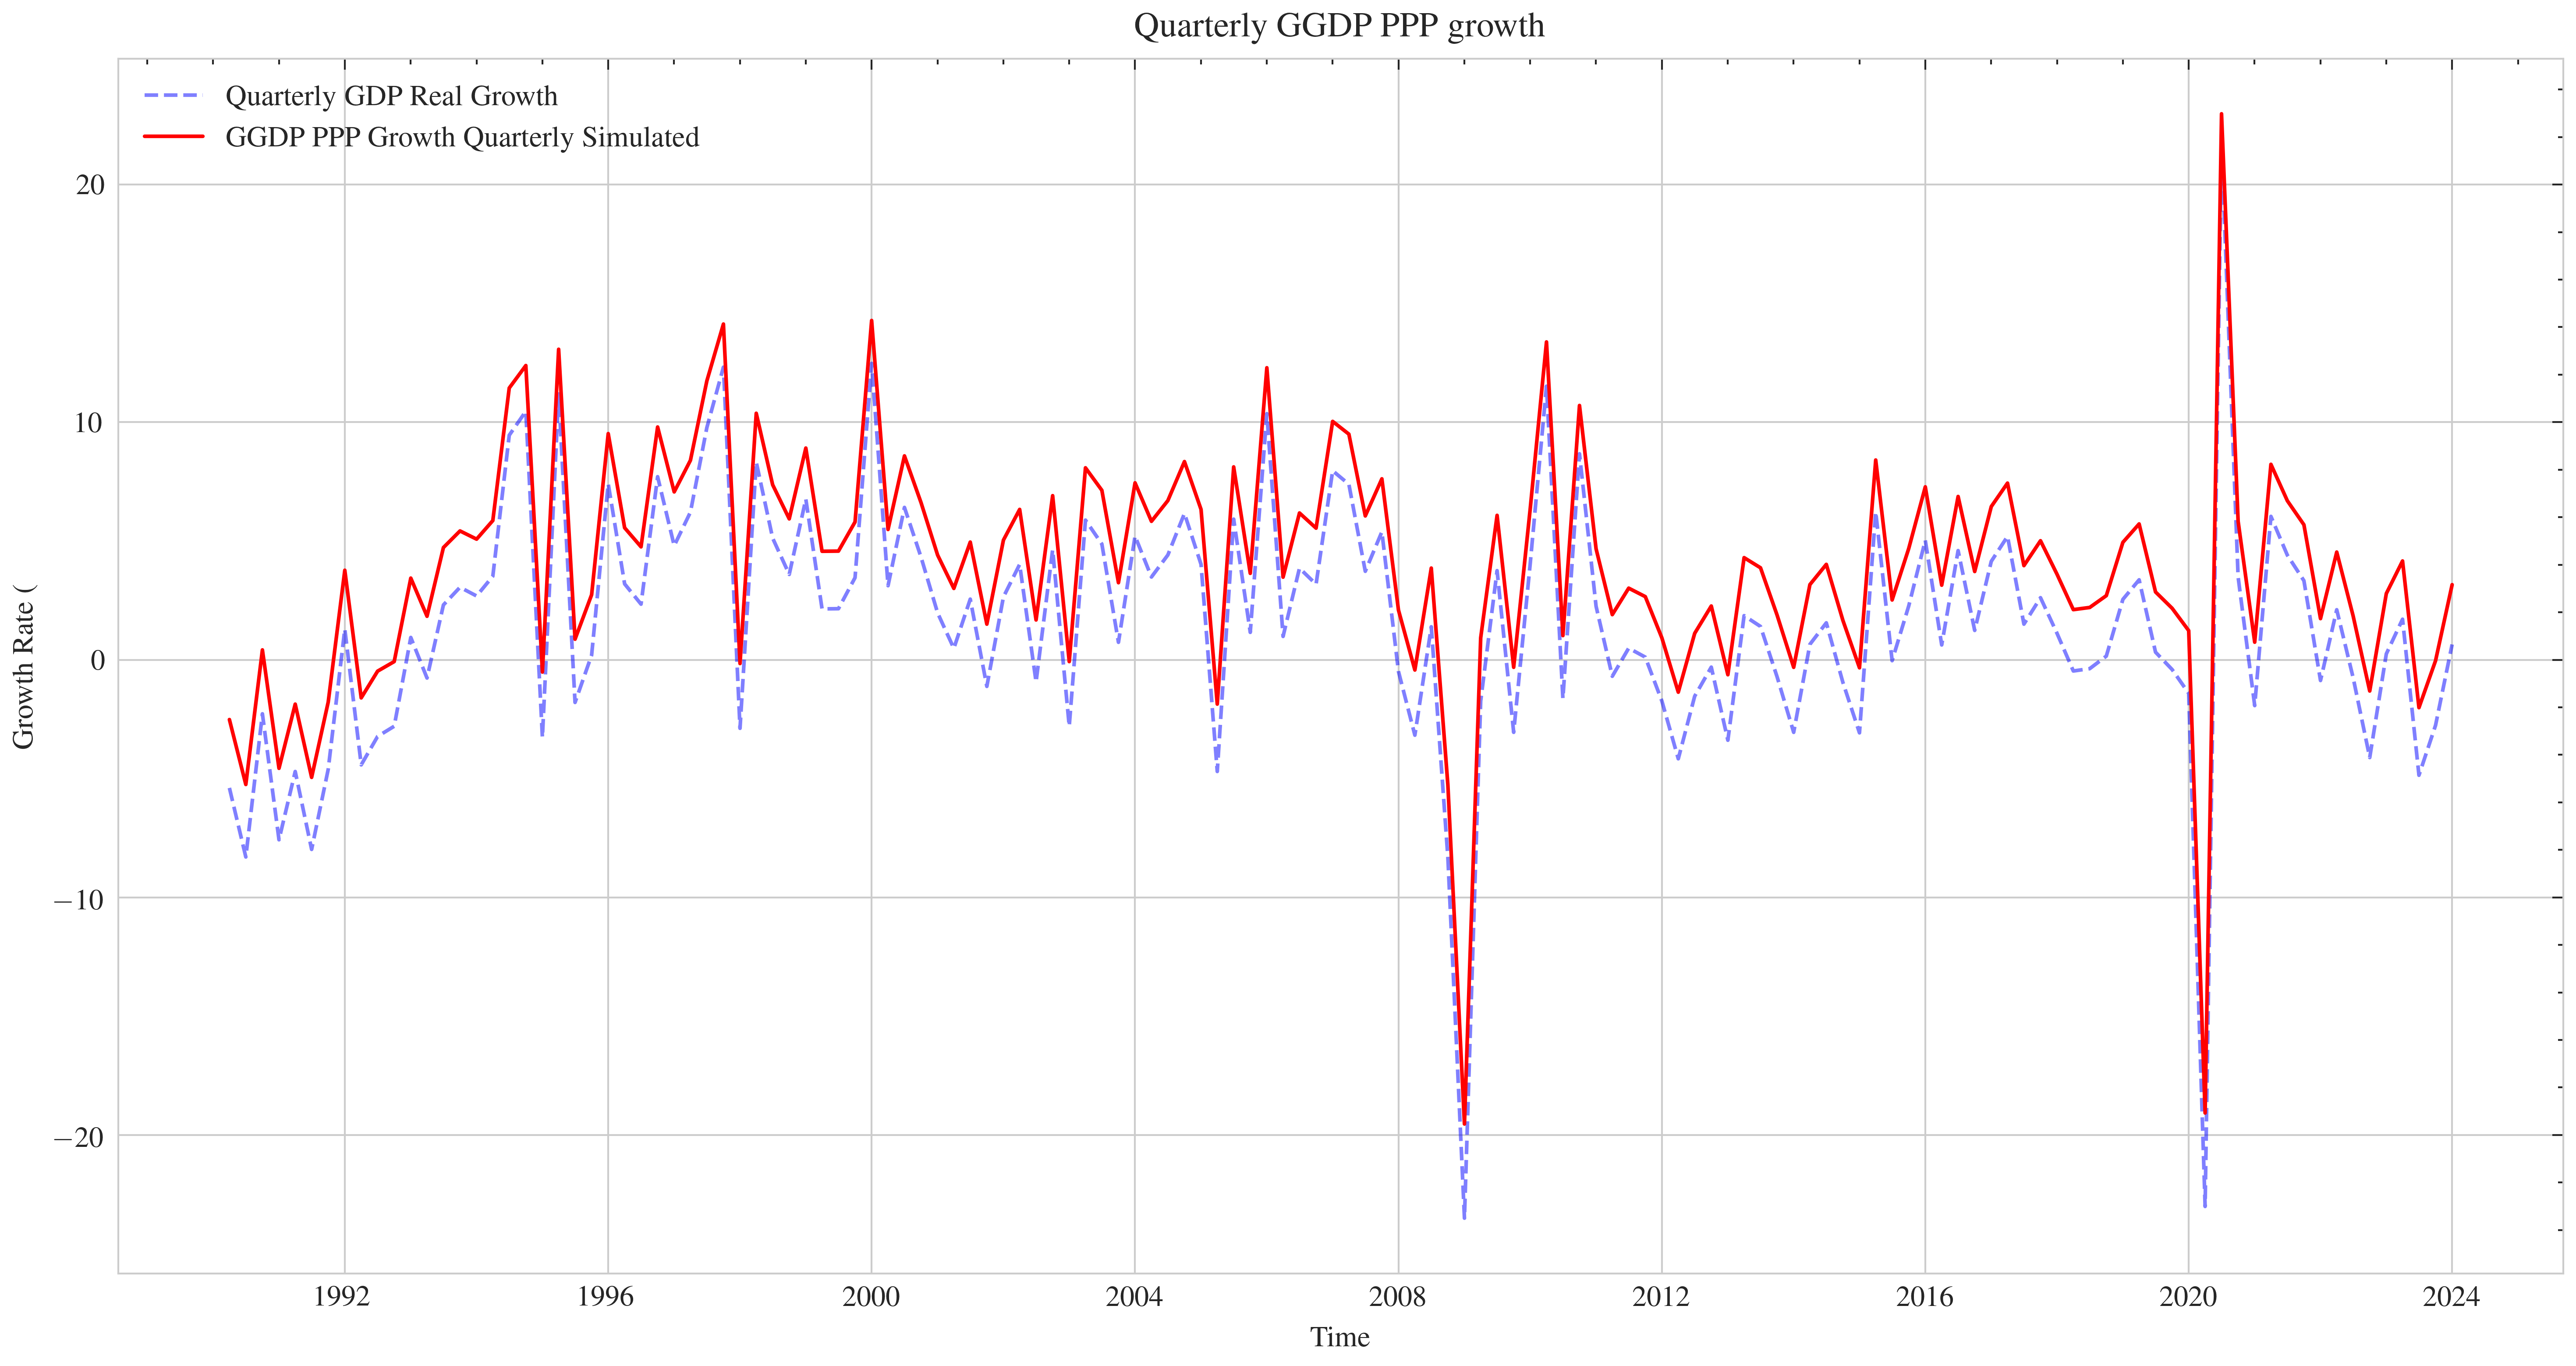

In [10]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

#Simulating quarterly GGDP based on quarterly GDP
gdp_quarterly_data = pd.read_csv('ggdp_data/finalnd_statistics_db/finland_quarterly_seasonally_adjuested_gdp.csv',
                                 header=0)
gdp_quarterly_data = gdp_quarterly_data.rename(
    columns={
        'Seasonally and per working day adjusted series, reference year 2015, millions of euro': "GDP 2015 EURO"})
gdp_quarterly_data.index = pd.to_datetime(gdp_quarterly_data['Quarter'])
gdp_quarterly_data['GDP 2015 EURO'] = pd.to_numeric(gdp_quarterly_data['GDP 2015 EURO'])
gdp_quarterly_data['quarterly_gdp_real_growth'] = gdp_quarterly_data['GDP 2015 EURO'] / gdp_quarterly_data[
    'GDP 2015 EURO'].shift(1) - 1

gdp_quarterly_data['quarterly_gdp_real_growth_annualized'] = gdp_quarterly_data['quarterly_gdp_real_growth'].apply(
    lambda x: (1 + x) ** 4 - 1)

# #convert lcu to real growth
# gdp_quarterly_data['real_quarterly_gdp'] = gdp_quarterly_data['value'] / gdp_quarterly_data['gdp_2015_dollar_deflator']

#using significant regression to simulate quarterly dynamics
gdp_quarterly_data['quarterly_ggdp_ppp_growth_annualized'] = ggdp_fit.params['Intercept'] + ggdp_fit.params[
    'gdp_real_growth'] * gdp_quarterly_data['quarterly_gdp_real_growth_annualized']


gdp_quarterly_data.index = pd.to_datetime(gdp_quarterly_data['Quarter'])
gdp_quarterly_data = gdp_quarterly_data.drop(columns=['Transaction', 'Quarter'])
gdp_quarterly_data.to_pickle('ggdp_processed_data/ggdp_ppp_quarterly_simulated_data.pkl')

t = gdp_quarterly_data.index

plt.figure(figsize=(12, 6))
plt.plot(t, gdp_quarterly_data['quarterly_gdp_real_growth_annualized'] * 100, 'b', alpha=0.5, linestyle='dashed')
plt.plot(t, gdp_quarterly_data['quarterly_ggdp_ppp_growth_annualized'] * 100, 'r')
plt.title("Quarterly GGDP PPP growth")
plt.xlabel("Time")
plt.ylabel("Growth Rate (%)")
plt.legend(['Quarterly GDP Real Growth', 'GGDP PPP Growth Quarterly Simulated'])
plt.grid(True)
plt.show()
